In [1]:
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import gym
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
print(gym.__version__)

0.15.7


# CONCETTI PRINCIPALI DQN

![POLICY_NETWORK](images/policy_network.png)<br>
Dopo aver memorizzato un'esperienza nella replay memory, si procede a campionare una batch casuale di esperienze dalla replay memory.
A partire da un singolo campione (generalizzando a una batch) di esperienza dalla memoria, si procede a una preelaborazione dello stato (conversione in scala di grigi, ritaglio, scalatura, ecc.) e si passa lo stato preelaborato alla rete come input. L'obiettivo della rete è quello di approssimare la policy ottimale trovando la Q-function ottimale.

I dati dello stato di input vengono propogati nella rete e vengono calcolati i Q-values per ciascuna azione in quello stato.

Si calcola quindi la loss. Per farlo, si confronta il valore Q emesso dalla rete per l'azione nella tupla di esperienza che abbiamo campionato e il corrispondente valore Q ottimale, o valore Q target, per la stessa azione.

Il valore Q target viene calcolato utilizzando l'espressione del lato destro dell'equazione di Bellman. Quindi la loss viene calcolata sottraendo il valore Q per una data coppia stato-azione dal valore Q ottimale per la stessa coppia stato-azione.

![TARGET_NETWORK](images/target_network.png)<br>
Per calcolare il target Q-value viene fatto un altro forward pass prendendo lo stato s' (next state) dalla tupla dell'esperienza campionata. Viene utilizzata una seconda rete (TARGET NETWORK), una copia della policy network (copia dei pesi dalla policy network periodicamente). Viene preso il Q-value massimo tra le possibili azioni.

Questo secondo forward pass serve quindi per aiutarci a calcolare la loss.

La discesa del gradiente viene quindi eseguita per aggiornare i pesi della rete nel tentativo di minimizzare la perdita. In questo caso, minimizzare la perdita significa puntare a far sì che la rete produca valori Q per ogni coppia stato-azione che si avvicinino ai valori Q target dati dall'equazione di Bellman.

Fino a questo punto, tutto ciò che abbiamo esaminato riguardava un singolo passo temporale. Passiamo quindi alla fase temporale successiva dell'episodio e ripetiamo questo processo più volte, finché non raggiungiamo la fine dell'episodio. A quel punto, iniziamo un nuovo episodio e continuiamo a farlo finché non raggiungiamo il numero massimo di episodi stabilito. Continueremo a ripetere questo processo fino a quando non avremo minimizzato a sufficienza la perdita.

RECAP

![algorithm](images/algorithm.png)<br>

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
# Use the Baseline Atari environment because of Deepmind helper functions
env = make_atari("BreakoutNoFrameskip-v4")
# Warp the frames, grey scale, stake four frame and scale to smaller ratio
env = wrap_deepmind(env, frame_stack=True, scale=True)
env.reset()

C:\Users\Livio\anaconda3\envs\dqn-breakout\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [6]:
state_dim = env.observation_space.shape
state_dim

(84, 84, 4)

In [7]:
n_actions = env.action_space.n
n_actions

4

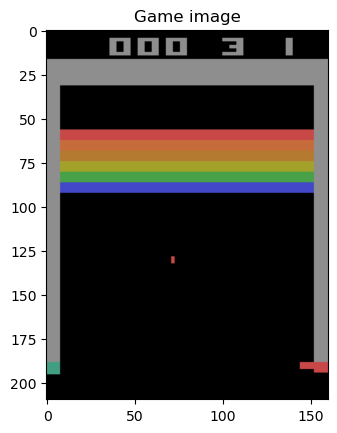

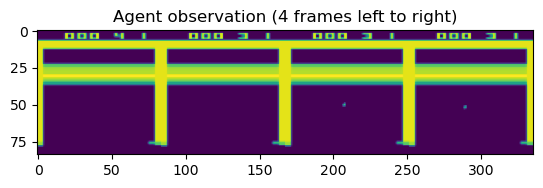

In [8]:
# review Atari image, and actual observation of the Agent after processing
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())
    
obs = np.array(obs)
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs.transpose([0,2,1]).reshape([state_dim[0],-1]));

# HYPER-PARAMETERS

In [9]:
'''#valori iniziali
batch_size = 256
gamma = 0.999 #fattore di sconto bellman equation
eps_start = 1 #valore iniziale epsilon
eps_end = 0.01 #valore finale epsilon
eps_decay = 0.001 #decay epsilon
target_update = 10 #frequenza (in episodi) con cui vengono aggiornati i pesi della target network
memory_size = 100000 #dimensione replay memory
lr = 0.001 #learning rate
num_episodes = 1000
'''

# DEEP Q-NETWORK

In [32]:
from keras.layers import Conv2D, Dense, Flatten
class DQN:
    def __init__(self, name, state_shape, n_actions, reuse=False):
        """A simple DQN agent"""
        with tf.variable_scope(name, reuse=reuse):
            
            self.network = keras.models.Sequential()
    
            # Keras ignores the first dimension in the input_shape, which is the batch size. 
            # So just use state_shape for the input shape
            self.network.add(Conv2D(32, (8, 8), strides=4, activation='relu',use_bias=False, input_shape=state_shape,kernel_initializer=tf.variance_scaling_initializer(scale=2)))
            self.network.add(Conv2D(64, (4, 4), strides=2, activation='relu',use_bias=False,kernel_initializer=tf.variance_scaling_initializer(scale=2)))
            self.network.add(Conv2D(64, (3, 3), strides=1, activation='relu',use_bias=False,kernel_initializer=tf.variance_scaling_initializer(scale=2)))
            self.network.add(Conv2D(1024, (7, 7), strides=1, activation='relu',use_bias=False,kernel_initializer=tf.variance_scaling_initializer(scale=2)))
            self.network.add(Flatten())
            self.network.add(Dense(n_actions, activation='linear',kernel_initializer=tf.variance_scaling_initializer(scale=2)))
            
            # prepare a graph for agent step
            self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
            self.qvalues_t = self.get_symbolic_qvalues(self.state_t)
            
        self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)

    def get_symbolic_qvalues(self, state_t):
        """takes agent's observation, returns qvalues. Both are tf Tensors"""
        qvalues = self.network(state_t)
        
        
        assert tf.is_numeric_tensor(qvalues) and qvalues.shape.ndims == 2, \
            "please return 2d tf tensor of qvalues [you got %s]" % repr(qvalues)
        assert int(qvalues.shape[1]) == n_actions
        
        return qvalues

# EXPERIENCE CLASS

In [13]:
from collections import namedtuple
Experience = namedtuple( 'Experience', ('state', 'action', 'next_state', 'reward'))

# REPLAY MEMORY

In [33]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = [] #lista per memorizzare le esperienze
        self.push_count = 0 #serve per tener traccia del numero di esperienze aggiunte in memoria

    def push(self, experience):
        #se la memoria non è piena
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else: #aggiungiamo la nuova esperienza al posto di quella più vecchia
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1

    #campiona un numero di batch_size esperienze dalla memoria in modo random
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
        
    #controlla se è possibile campionare dalla memoria, ossia se ci sono abbastanza esperienze nella memoria rispetto alla batch size
    def can_provide_sample(self, batch_size):
        return len(self_memory) >= batch_size

# EPSILON GREEDY STRATEGY

In [22]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self_decay)

# AGENT CLASS

In [23]:
class Agent():
    def __init__(self, strategy, num_actions):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions

    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self_current_step += 1

        if rate > random.random():
            return random.randrange(self.num_actions) #explore
        else: 
            with tf.stop_gradients():
                return policy_net(state).argmax(dim=1).item() #exploit
        